In [11]:
from datasets import load_dataset
import torch
import os
import pickle
import random
random.seed(1330) 
import regex as re
from tokenizer import RegExpTokenizer

name = "RegexToken3000"

ds = load_dataset("statworx/haiku")
haikutext = '\n'.join(ds['train']['text'])
vocab_size = 3000
tokenizer = RegExpTokenizer()
tokens = tokenizer.encode(haikutext, vocab_size, verbose=False)


In [12]:
data = torch.tensor(tokens, dtype=torch.long)

#train test split
n = int(0.80*len(data)) # first 80% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Model Train

In [13]:
# hyperparameters

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #m1 gpu
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 256 # what is the maximum context length for predictions
max_iters = 20000 # epochs/learning iterations
eval_interval = 100 # for printing loss updates
checpoint_interval = 1000 #save checkpoint
learning_rate = 3e-4 # Slower learning rate for wide model
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
n_block_layers = 6
dropout = 0.2

In [18]:
from BigramLanguageModelTrain import utilTools as ut
from BigramLanguageModelTrain import BigramLanguageModel


#Relearning Epoch starting point
iterationStart = 15300


#Stopping criteria parameters
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


util_tools = ut(train_data, val_data, block_size, batch_size, device)
model = BigramLanguageModel(block_size, vocab_size, n_embd, n_head, dropout, device)

if os.path.exists(f'.losses{name}/trainlosses_{iterationStart}.pkl'):
    with open(f'.losses{name}/trainlosses_{iterationStart}.pkl', "rb") as file:
        print("Loading losses")
        trainlosses = pickle.load(file)
else:
    trainlosses = []

if os.path.exists(f'.losses{name}/vallosses_{iterationStart}.pkl'):
    with open(f'.losses{name}/vallosses_{iterationStart}.pkl', "rb") as file:
        vallosses = pickle.load(file)
        print("Loading losses")
else:
    vallosses = []


if os.path.exists(f'./model_weights{name}/model_weights_{iterationStart}.pth'):
    print("Loading from previous checkpoint", f"'./model_weights{name}/model_weights_{iterationStart}.pth'")
    # Load previous weights
    model.load_state_dict(torch.load(f'./model_weights{name}/model_weights_{iterationStart}.pth', weights_only=True))
    print("Weights loaded")

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter >10000:
        learning_rate = 3e-5
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = util_tools.estimate_loss(model, eval_iters)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trainlosses.append(losses['train'])
        vallosses.append(losses['val'])

        #Stopping Criteria
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print("Early stopping")
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            break
    if iter % checpoint_interval ==0 and iter >0:
        # Save the weights checkpoint
        torch.save(model.state_dict(), f"./model_weights{name}/model_weights_{iter+iterationStart}.pth")

    # sample a batch of data
    xb, yb = util_tools.get_batch(split ='train')
    xb, yb = xb.to(device), yb.to(device)


    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
print("Train complete")
# Save the weights
torch.save(model.state_dict(), f"./model_weights{name}/model_weights_{iter+iterationStart}.pth")
with open(f"./losses{name}/trainlosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(trainlosses, file)
with open(f"./losses{name}/vallosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(vallosses, file)

Loading from previous checkpoint './model_weightsRegexToken3000/model_weights_15300.pth'


/opt/anaconda3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Weights loaded
7.726008 M parameters
step 0: train loss 1.3741, val loss 2.8403
step 100: train loss 1.3264, val loss 2.8028
step 200: train loss 1.3097, val loss 2.7743
step 300: train loss 1.2993, val loss 2.7642
step 400: train loss 1.2868, val loss 2.7422
step 500: train loss 1.2841, val loss 2.7599
step 600: train loss 1.2779, val loss 2.7484
step 700: train loss 1.2717, val loss 2.7320
step 800: train loss 1.2662, val loss 2.7071
step 900: train loss 1.2624, val loss 2.7129
step 1000: train loss 1.2592, val loss 2.7462
step 1100: train loss 1.2554, val loss 2.7361
step 1200: train loss 1.2480, val loss 2.7384
step 1300: train loss 1.2445, val loss 2.7704
step 1400: train loss 1.2423, val loss 2.7563
step 1500: train loss 1.2374, val loss 2.7544
step 1600: train loss 1.2382, val loss 2.7037
step 1700: train loss 1.2347, val loss 2.6937
step 1800: train loss 1.2305, val loss 2.7110
step 1900: train loss 1.2298, val loss 2.6901
step 2000: train loss 1.2220, val loss 2.7104
step 2100

In [7]:
def load_pkl_file(file_path):
    with open(file_path, 'rb') as file:
        return list(pickle.load(file))
    
trainlossfile = sorted([item for item in os.listdir(f'./losses{name}') if 'train' in item])
vallossfile = sorted([item for item in os.listdir(f'./losses{name}') if 'val' in item])
traininglosses = []
vallosses = []
for i in range(0, len(trainlossfile)):
    traininglosses.extend(load_pkl_file(f'./losses{name}/{trainlossfile[i]}'))
    vallosses.extend(load_pkl_file(f'./losses{name}/{vallossfile[i]}'))

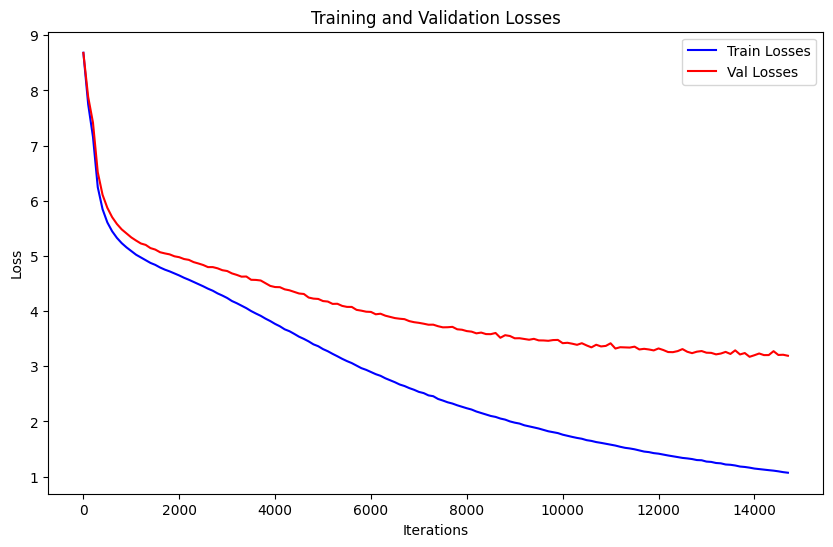

In [8]:
import matplotlib.pyplot as plt
# Create the plot
x_values = list(range(0,len(traininglosses)*100,100))
plt.figure(figsize=(10, 6))

# Plot the training losses
plt.plot(x_values, traininglosses, label='Train Losses', color='blue')
# Plot the validation losses
plt.plot(x_values, vallosses, label='Val Losses', color='red')
# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
# Add a legend
plt.legend()
# Show the plot
plt.show()